In [2]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve 
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

print(halophot.__version__)

Populating the interactive namespace from numpy and matplotlib
0.6.6.3


In [3]:
ls ../data/

all_targets_S003_v1.txt
tess-s0003-1-2_26.0170142608_-15.9374795978_20x20_astrocut.fits
tess-s0003-1-2_26.0170142608_-15.9374795978_25x35_astrocut.fits
tess-s0003-1-2_26.0170142608_-15.9374795978_50x20_astrocut.fits
tess2018263035959-s0003-0000000419015728-0123-s_lc.fits
tess2018263035959-s0003-0000000419015728-0123-s_tp.fits


In [20]:
fname = '../data/tess-s0003-1-2_26.0170142608_-15.9374795978_50x100_astrocut.fits'

In [21]:
tpf = lightkurve.open(fname)

In [22]:
bg = tpf.get_bkg_lightcurve()

In [23]:
np.nanmax(tpf.flux)

108081.75

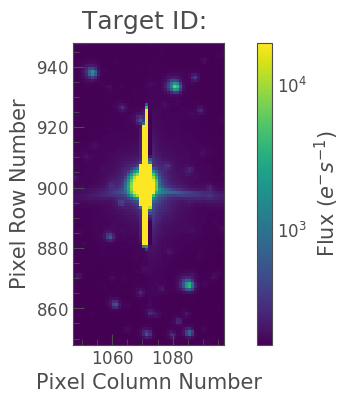

In [24]:
tpf.plot(frame=1,scale='log')
plt.savefig('brightest.png')

In [25]:
tpf.interact()

In [48]:
nmax = 15
nmin = 5
newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')
xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))
rr = np.sqrt((xx-newmask.shape[0]/2)**2 + (yy-newmask.shape[1]/2)**2)

newmask[(rr>nmax).T] = False
newmask[(rr<nmin).T] = False
# newmask[(np.abs(xx-newmask.shape[0]/2+-10)<6.).T] = True
newmask[(np.abs(yy-newmask.shape[1]/2+2)<5).T] = False

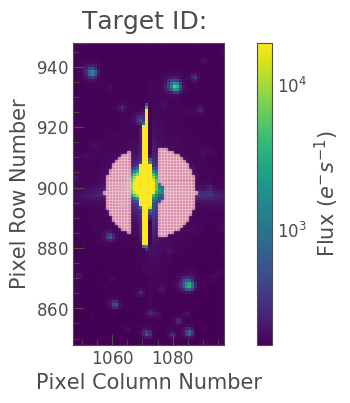

In [49]:
tpf.plot(frame=1,aperture_mask=newmask,scale='log')
plt.savefig('special_aperture.png')

In [50]:
lc = tpf.to_lightcurve(aperture_mask=newmask)
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header


(0.9, 1.1)

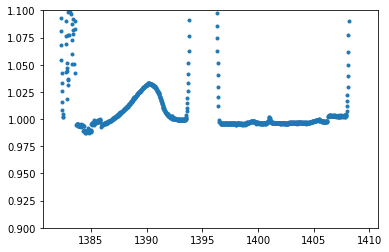

In [51]:
plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.')
plt.ylim(0.9,1.1)

## Now to do Halophot


In [52]:
tpf = halo_tpf(fname)

In [53]:
%%time
weightmap, corr_lc = tpf.halo(order=1,mask=newmask,thresh=0.8);

Taking cadences from beginning to end
6 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 1.65 s, sys: 228 ms, total: 1.88 s
Wall time: 850 ms


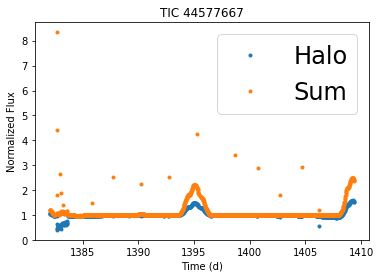

In [54]:
plt.plot(corr_lc.time,corr_lc.flux/np.nanmedian(corr_lc.flux),'.',label='Halo')
plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.',label='Sum')
# plt.ylim(0.98,1.05)
plt.legend(fontsize=24)
plt.ylabel('Normalized Flux')
plt.xlabel('Time (d)')
plt.title('TIC 44577667')
plt.savefig('halotest.png')

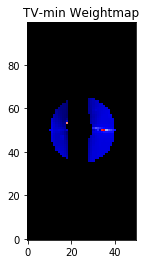

In [55]:
cmap = mpl.cm.seismic
weightmap = weightmap['weightmap']
norm = np.size(weightmap)
cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
# plt.colorbar()
plt.title('TV-min Weightmap')
plt.savefig('tess_weightmap.png')

### This is clearly garbage - we only get ok results on the pipeline 